In [57]:
import itertools as it
import copy
import json
import os.path as op
import pickle
import matplotlib.pylab as plt
from matplotlib import colors
from extra.tools import many_is_in
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
from sklearn.preprocessing import RobustScaler
from sklearn.decomposition import PCA
from scipy.linalg import eig
from scipy.stats import spearmanr

In [2]:
scaler_path = "/home/mszul/datasets/explicit_implicit_beta/derivatives/PCA_results/scaler_MEG.pkl"
PCA_path = "/home/mszul/datasets/explicit_implicit_beta/derivatives/PCA_results/pca_solution_MEG.pkl"
all_info = "/home/mszul/datasets/explicit_implicit_beta/derivatives/PCA_results/sub_metrics.pkl"
burst_features_file = "/home/mszul/datasets/explicit_implicit_beta/derivatives/PCA_results/burst_features_sensors.csv"
waveforms_path = "/home/mszul/datasets/explicit_implicit_beta/derivatives/PCA_results/waveforms_sensors.npy"

In [3]:
if op.exists(burst_features_file):
    output_dict = pd.read_csv(burst_features_file)
    with open(PCA_path, "rb") as input_file:
        big_pca = pickle.load(input_file)

    with open(scaler_path, "rb") as input_file:
        big_scaler = pickle.load(input_file)
else:
    sub_metrics = pickle.load(open(all_info, "rb"))
    scaler_meg = pickle.load(open(scaler_path, "rb"))
    PCA_saved = pickle.load(open(PCA_path, "rb"))
    features_columns = [
        "peak_time", "peak_freq", "peak_amp_base", 
        "fwhm_freq", "fwhm_time", "trial", "pp_ix", "block", 
        "sensor", "trial_type", "subject", "polarity"
    ]
    PC_columns = ["PC_" + str(i+1) for i in range(20)]

    columns = features_columns + PC_columns

    output_dict = {i: [] for i in columns}

    for sub in tqdm(sub_metrics.keys()):
        for cat in ["vis", "mot"]:
            for ft in features_columns:
                shape = len(sub_metrics[sub][cat]["peak_time"])
                if ft == "trial_type":
                    output_dict["trial_type"].append([cat] * shape)
                elif ft == "subject":
                    output_dict["subject"].append([sub] * shape)
                else:
                    output_dict[ft].append(sub_metrics[sub][cat][ft])
            PCS = PCA_saved.transform(scaler_meg.transform(sub_metrics[sub][cat]["waveform"]))
            for PC_ix, PC_lab in enumerate(PC_columns):
                output_dict[PC_lab].append(PCS[:,PC_ix])
    output_dict = {i: np.hstack(output_dict[i]).flatten() for i in columns}
    output_dict = pd.DataFrame.from_dict(output_dict)
    output_dict.to_csv(burst_features_file, index=False)

  0%|          | 0/37 [00:00<?, ?it/s]

In [15]:
if op.exists(waveforms_path):
    waveforms = np.load(waveforms_path)
else:
    waveforms = []
    for sub in tqdm(sub_metrics.keys()):
        for cat in ["vis", "mot"]:
            waveforms.append(sub_metrics[sub][cat]["waveform"])
    waveforms = np.vstack(waveforms)
    np.save(waveforms_path, waveforms)

  0%|          | 0/37 [00:00<?, ?it/s]

In [6]:
with open(PCA_path, "rb") as input_file:
    big_pca = pickle.load(input_file)

with open(scaler_path, "rb") as input_file:
    big_scaler = pickle.load(input_file)

In [7]:
big_pca.components_.shape

(20, 156)

In [18]:
output_dict.polarity.values.astype(bool)

array([False, False,  True, ..., False, False, False])

In [16]:
waveforms.shape

(14330032, 156)

In [35]:
max_wvf = np.max(waveforms, axis=1)
max_wvf_prc = [np.percentile(max_wvf, 1), np.percentile(max_wvf, 99)]
max_wvf_map = ((mean_wvf >= mean_wvf_prc[0]) & (mean_wvf <= mean_wvf_prc[1]))

In [36]:
polarity = output_dict.polarity.values.astype(bool)[max_wvf_map]
waveforms_pol = waveforms[max_wvf_map]

In [38]:
flipped = waveforms_pol[polarity]
unflipped = waveforms_pol[~polarity]

In [41]:
flipped_PCA = PCA(n_components=20)
unflipped_PCA = PCA(n_components=20)
flipped_PCA.fit(big_scaler.transform(flipped))
unflipped_PCA.fit(big_scaler.transform(unflipped))

PCA(n_components=20)

In [56]:
flipped_comps = flipped_PCA.transform(big_scaler.transform(flipped))
unflipped_comps = unflipped_PCA.transform(big_scaler.transform(unflipped))

In [54]:
components_range = list(it.product(range(20), repeat=2))

In [135]:
f_r = np.zeros((20,20))
f_p = np.zeros((20,20))

for r, c in components_range:
    f_r[r,c], f_p[r,c] = spearmanr(
        flipped_PCA.components_[r],
        unflipped_PCA.components_[c]
    )

af_r = np.zeros((20,20))
af_p = np.zeros((20,20))

for r, c in components_range:
    af_r[r,c], af_p[r,c] = spearmanr(
        big_pca.components_[r],
        flipped_PCA.components_[c]
    )


auf_r = np.zeros((20,20))
auf_p = np.zeros((20,20))

for r, c in components_range:
    auf_r[r,c], auf_p[r,c] = spearmanr(
        big_pca.components_[r],
        unflipped_PCA.components_[c]
    )

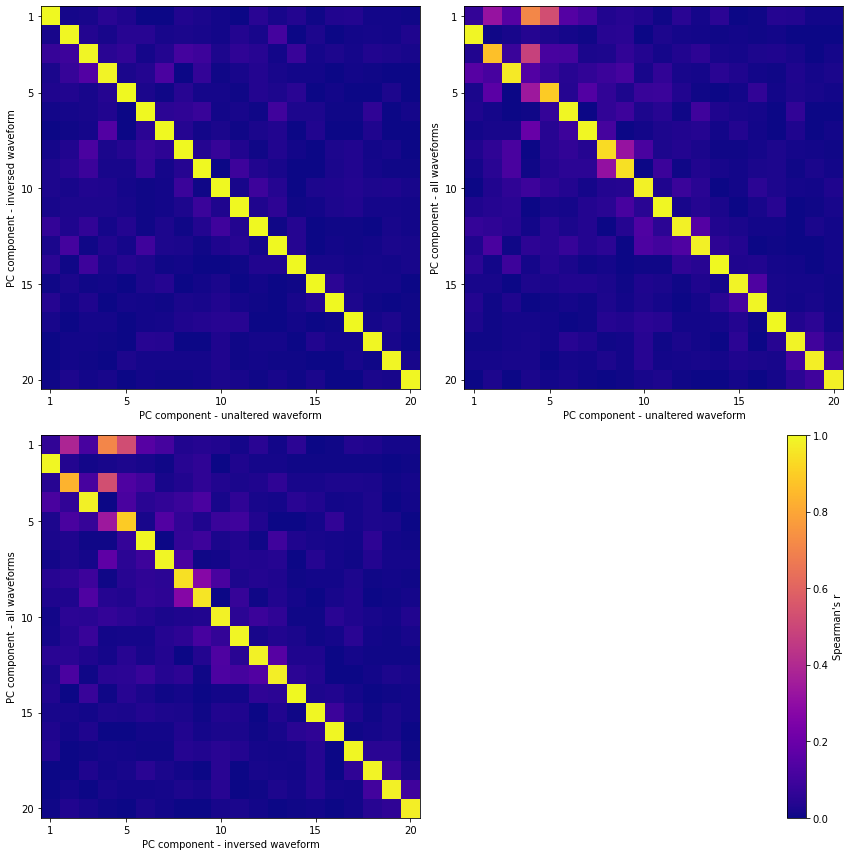

In [189]:
f, ax = plt.subplots(2,2, figsize=[12,12], facecolor="white")
x = ax[0,0].imshow(
    np.abs(f_r), origin="upper",
    aspect="auto",
    extent=[0,20,20,0],
    vmin=0, vmax=1,
    cmap="plasma"
)

tick_labels = np.array([1, 5, 10, 15, 20])
ticks = tick_labels - 0.5
ax[0,0].set_xticks(ticks)
ax[0,0].set_yticks(ticks)
ax[0,0].set_xticklabels(tick_labels)
ax[0,0].set_yticklabels(tick_labels)
ax[0,0].set_xlabel("")
ax[0,0].set_ylabel("PC component - inversed waveform")
ax[0,0].set_xlabel("PC component - unaltered waveform")

x = ax[1,0].imshow(
    np.abs(af_r), origin="upper",
    aspect="auto",
    extent=[0,20,20,0],
    vmin=0, vmax=1,
    cmap="plasma"
)
ax[1,0].set_xticks(ticks)
ax[1,0].set_yticks(ticks)
ax[1,0].set_xticklabels(tick_labels)
ax[1,0].set_yticklabels(tick_labels)
ax[1,0].set_xlabel("")
ax[1,0].set_ylabel("PC component - all waveforms")
ax[1,0].set_xlabel("PC component - inversed waveform")

x = ax[0,1].imshow(
    np.abs(auf_r), origin="upper",
    aspect="auto",
    extent=[0,20,20,0],
    vmin=0, vmax=1,
    cmap="plasma"
)

ax[0,1].set_xticks(ticks)
ax[0,1].set_yticks(ticks)
ax[0,1].set_xticklabels(tick_labels)
ax[0,1].set_yticklabels(tick_labels)
ax[0,1].set_xlabel("")
ax[0,1].set_ylabel("PC component - all waveforms")
ax[0,1].set_xlabel("PC component - unaltered waveform")

ax[1,1].axis("off")
plt.colorbar(x, label="Spearman's r")
plt.tight_layout()
plt.savefig("/home/mszul/datasets/explicit_implicit_beta/derivatives/PCA_results/images/pca_eigenvector_polarity.svg")

In [116]:
np.array([1, 5, 10, 15, 20])

array([ 1,  5, 10, 15, 20])

In [102]:
ticks = np.linspace(0,20, num=5)

In [108]:
ticks[0] = 1.5

In [185]:
af_r[0,0]

-0.06569518420761486

In [183]:
auf_r[0,0]

-0.06713344186120024